In [1]:
NAME = "Jake Singleton"
COLLABORATORS = "Cole Striler"

---

# Project 2: NYC Taxi Rides
# Modeling

In [2]:
# Imports
import os
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sqlalchemy import create_engine
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from pathlib import Path
import zipfile
from sklearn.metrics import r2_score, make_scorer, mean_absolute_error

sns.set(style="whitegrid", palette="muted")

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

%matplotlib inline

In [3]:
# Useful functions.
def haversine(lat1, lng1, lat2, lng2):
    """
    Compute haversine distance
    """
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    average_earth_radius = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * average_earth_radius * np.arcsin(np.sqrt(d))
    return h

def manhattan_distance(lat1, lng1, lat2, lng2):
    """
    Compute Manhattan distance
    """
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

def bearing(lat1, lng1, lat2, lng2):
    """
    Compute the bearing, or angle, from (lat1, lng1) to (lat2, lng2).
    A bearing of 0 refers to a NORTH orientation.
    """
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

def add_time_columns(df):
    """
    Add temporal features to df
    """
    df.is_copy = False # propogate write to original dataframe
    df.loc[:, 'month'] = df['tpep_pickup_datetime'].dt.month
    df.loc[:, 'week_of_year'] = df['tpep_pickup_datetime'].dt.weekofyear
    df.loc[:, 'day_of_month'] = df['tpep_pickup_datetime'].dt.day
    df.loc[:, 'day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df.loc[:, 'hour'] = df['tpep_pickup_datetime'].dt.hour
    df.loc[:, 'week_hour'] = df['tpep_pickup_datetime'].dt.weekday * 24 + df['hour']
    return df

def add_distance_columns(df):
    """
    Add distance features to df
    """
    df.is_copy = False # propogate write to original dataframe
    df.loc[:, 'manhattan'] = manhattan_distance(lat1=df['pickup_latitude'],
                                                lng1=df['pickup_longitude'],
                                                lat2=df['dropoff_latitude'],
                                                lng2=df['dropoff_longitude'])

    df.loc[:, 'bearing'] = bearing(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    df.loc[:, 'haversine'] = haversine(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    return df

def select_columns(data, *columns):
    return data.loc[:, columns]

# Training Data Selection

In [5]:
DB_URI = "sqlite:////srv/db/taxi_2016_student_small.sqlite"
TABLE_NAME = 'taxi'

sql_engine = create_engine(DB_URI)

In [5]:
data_query = f"""
                 SELECT *
                 FROM {TABLE_NAME}
                 WHERE record_id % 100 = 0
                 ORDER BY tpep_pickup_datetime
           """
dat = pd.read_sql_query(data_query, sql_engine)
dat.head()

,record_id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,37300,1,2016-01-01 00:02:20,2016-01-01 00:11:58,2,1.20,-73.990578,40.732883,1,N,-73.982307,40.747406,2,8.0,0.5,0.5,0.00,0.0,0.3,9.30
1,37400,1,2016-01-01 00:03:04,2016-01-01 00:28:54,1,5.00,-73.994286,40.749153,1,N,-73.956688,40.747395,1,20.5,0.5,0.5,1.09,0.0,0.3,22.89
2,37500,2,2016-01-01 00:03:40,2016-01-01 00:12:47,6,2.54,-73.949821,40.785412,1,N,-73.974586,40.758282,1,9.5,0.5,0.5,2.16,0.0,0.3,12.96
3,37900,2,2016-01-01 00:05:38,2016-01-01 00:10:02,3,0.76,-74.002998,40.739220,1,N,-74.006714,40.744259,2,5.0,0.5,0.5,0.00,0.0,0.3,6.30
4,38500,1,2016-01-01 00:07:50,2016-01-01 00:23:42,1,2.40,-73.992546,40.766624,1,N,-73.958771,40.763844,1,12.0,0.5,0.5,2.00,0.0,0.3,15.30


In [6]:
# Add important columns
dat['tpep_pickup_datetime'] = pd.to_datetime(dat['tpep_pickup_datetime'])
dat['tpep_dropoff_datetime'] = pd.to_datetime(dat['tpep_dropoff_datetime'])
dat['pickup_date'] = dat.loc[:, 'tpep_pickup_datetime'].dt.date
dat['duration'] = dat["tpep_dropoff_datetime"]-dat["tpep_pickup_datetime"]
dat['duration'] = dat['duration'].dt.total_seconds()
#new_data_df['date'] = new_data_df['tpep_pickup_datetime'].dt.date

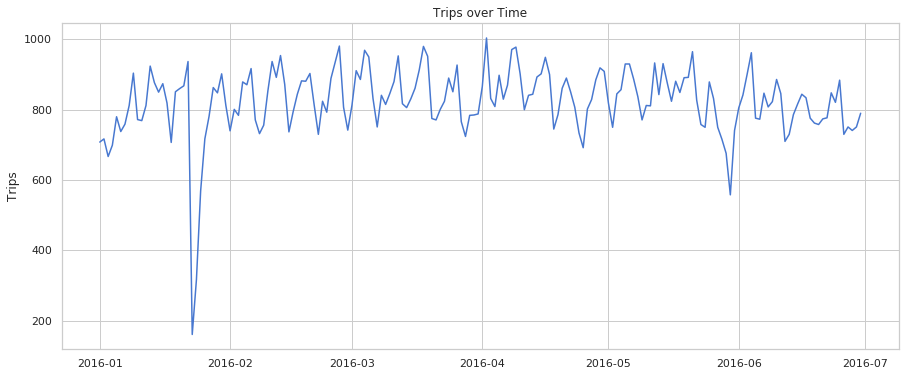

In [7]:
plt.figure(figsize=(15,6))
plt.plot(dat.groupby('pickup_date').count()[['record_id']], '-')
plt.title('Trips over Time')
plt.ylabel('Trips')
plt.show();

In [8]:
# Select rides not affected by the blizzard, as we saw in the visualization above.
new_data_query = f"""
                 SELECT *
                 FROM {TABLE_NAME}
                 WHERE tpep_pickup_datetime NOT BETWEEN '2016-01-21' AND '2016-01-26'
                 AND record_id % 100 = 0
                 ORDER BY tpep_pickup_datetime
           """

new_data_df = pd.read_sql_query(new_data_query, sql_engine)
new_data_df.shape

(147003, 20)

In [9]:
# Add important columns
new_data_df['tpep_pickup_datetime'] = pd.to_datetime(new_data_df['tpep_pickup_datetime'])
new_data_df['tpep_dropoff_datetime'] = pd.to_datetime(new_data_df['tpep_dropoff_datetime'])
new_data_df['pickup_date'] = new_data_df.loc[:, 'tpep_pickup_datetime'].dt.date
new_data_df['duration'] = new_data_df["tpep_dropoff_datetime"]-new_data_df["tpep_pickup_datetime"]
new_data_df['duration'] = new_data_df['duration'].dt.total_seconds()
#new_data_df['date'] = new_data_df['tpep_pickup_datetime'].dt.date

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


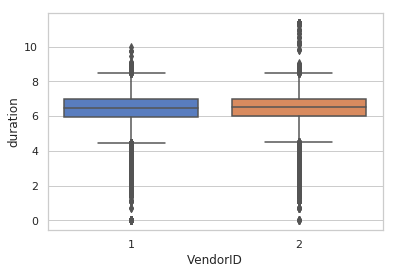

In [10]:
# Visualization
sns.boxplot(x='VendorID', y=np.log(new_data_df['duration']+1), data=new_data_df);

In [11]:
upper_bound = np.mean(new_data_df['duration']) + (2 * np.std(new_data_df['duration']))

print('Upper Bound:', upper_bound)

Upper Bound: 7431.62807698


In [12]:
# Drop outliers 
# i.e. drop rows outside of 2 SDs from mean of duration
new_data_df = new_data_df[(new_data_df['duration'] < upper_bound) | (new_data_df['duration'] < 0)]

# Drop rides not in NYC
new_data_df = new_data_df[(new_data_df['pickup_longitude'] <= -73.75) & (new_data_df['pickup_longitude'] >= -74.03)
                         & (new_data_df['pickup_latitude'] <= 40.85) & (new_data_df['pickup_latitude'] >= 40.63)
                         & (new_data_df['dropoff_longitude'] <= -73.75) & (new_data_df['dropoff_longitude'] >= -74.03)
                         & (new_data_df['dropoff_latitude'] >= 40.63) & (new_data_df['dropoff_latitude'] <= 40.85)]

# Drop rides with negative passenger counts
new_data_df = new_data_df[new_data_df['passenger_count'] > 0]
new_data_df.shape

(142478, 22)

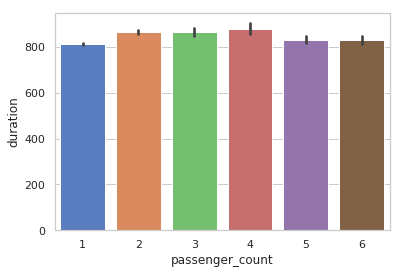

In [13]:
sns.barplot(x='passenger_count', y='duration', data=new_data_df);

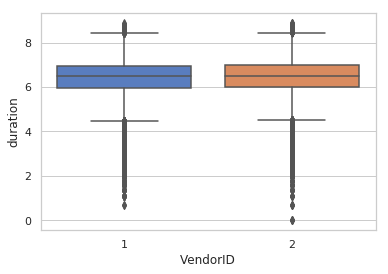

In [14]:
# Make sure outliers are gone.
sns.boxplot(x='VendorID', y=np.log(new_data_df['duration']+1), data=new_data_df);

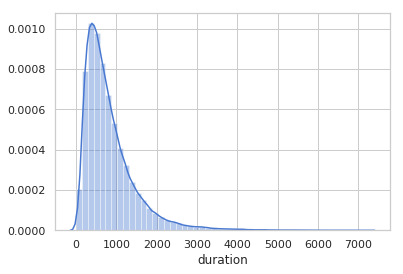

In [15]:
sns.distplot(new_data_df['duration']);

In [16]:
new_data_df.columns

Index(['record_id', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount', 'pickup_date',
       'duration'],
      dtype='object')

In [17]:
# Load collisions data.
#data_file = Path("data/final", "collisions.hdf")
#collisions = pd.read_hdf(data_file, "collisions")

In [18]:
#collisions_subset = collisions.loc[:, ['DATETIME', 'TIME', 'START', 'END', 'DATE', 'LATITUDE', 'LONGITUDE',
#                                      'SEVERITY']]
#collisions_subset = collisions_subset[(collisions_subset['DATETIME'] <= '2016-03-07') & (collisions_subset['DATETIME'] >= '2016-03-01')]
#collisions_subset.head()

In [19]:
#collisions_subset.shape

In [20]:
# Merge collisions with new_data_df
#merged = new_data_df.merge(collisions_subset, how='left', left_on='date', right_on='DATE')

In [21]:
Path("data/final").mkdir(parents=True, exist_ok=True)
data_file = Path("data/final", "new_data_df.hdf") # Path of hdf file
new_data_df.to_hdf(data_file, "new_data_df") # Train data of hdf file

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['store_and_fwd_flag', 'pickup_date']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


## Feature Engineering

In [22]:
# Add useful columns
featured_df = add_distance_columns(new_data_df)
featured_df = add_time_columns(new_data_df)
featured_df.head()

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


,record_id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,duration,manhattan,bearing,haversine,month,week_of_year,day_of_month,day_of_week,hour,week_hour
0,37300,1,2016-01-01 00:02:20,2016-01-01 00:11:58,2,1.20,-73.990578,40.732883,1,N,...,578.0,2.311679,23.336532,1.758743,1,53,1,4,0,96
1,37400,1,2016-01-01 00:03:04,2016-01-01 00:28:54,1,5.00,-73.994286,40.749153,1,N,...,1550.0,3.362713,93.520706,3.173241,1,53,1,4,0,96
2,37500,2,2016-01-01 00:03:40,2016-01-01 00:12:47,6,2.54,-73.949821,40.785412,1,N,...,547.0,5.101761,-145.335971,3.667396,1,53,1,4,0,96
3,37900,2,2016-01-01 00:05:38,2016-01-01 00:10:02,3,0.76,-74.002998,40.739220,1,N,...,264.0,0.873371,-29.188145,0.641841,1,53,1,4,0,96
4,38500,1,2016-01-01 00:07:50,2016-01-01 00:23:42,1,2.40,-73.992546,40.766624,1,N,...,952.0,3.153657,96.193207,2.861252,1,53,1,4,0,96


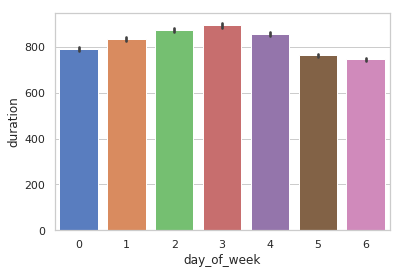

In [23]:
plt1 = sns.barplot(x='day_of_week', y='duration', data=featured_df)

fig = plt1.get_figure()
fig.savefig('duration vs. day of week.png');

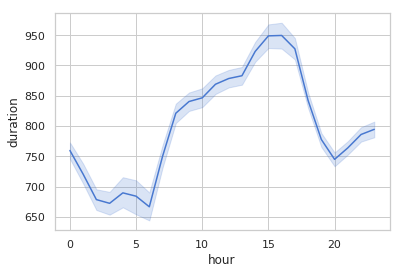

In [24]:
plt2 = sns.lineplot(x='hour', y='duration', data=featured_df)

fig = plt2.get_figure()
fig.savefig('duration vs. hour.png');

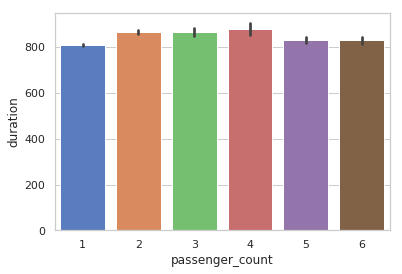

In [25]:
plt3 = sns.barplot(x='passenger_count', y='duration', data=featured_df);

fig = plt3.get_figure()
fig.savefig('duration vs. passenger count.png');

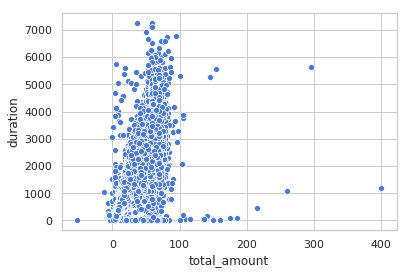

In [26]:
plt4 = sns.scatterplot(x='total_amount', y='duration', data=featured_df);

fig = plt4.get_figure()
fig.savefig('duration vs. total_amount.png');

In [27]:
# One hot encode useful categorical features.
dow = pd.get_dummies(featured_df['day_of_week'], prefix='dow', prefix_sep='_')
month = pd.get_dummies(featured_df['month'], prefix='m', prefix_sep='_')
hour = pd.get_dummies(featured_df['hour'], prefix='h', prefix_sep='_')
passengers = pd.get_dummies(featured_df['passenger_count'], prefix='num_pass', prefix_sep='_')

In [28]:
featured_df.tail()

,record_id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,duration,manhattan,bearing,haversine,month,week_of_year,day_of_month,day_of_week,hour,week_hour
146998,69092100,1,2016-06-30 23:57:04,2016-06-30 23:59:35,1,0.60,-73.909798,40.753113,1,N,...,151.0,0.862487,-22.056117,0.662251,6,26,30,3,23,95
146999,69092500,2,2016-06-30 23:57:40,2016-07-01 00:04:43,1,1.26,-73.974312,40.759876,1,N,...,423.0,2.401772,39.587831,1.705834,6,26,30,3,23,95
147000,69092700,1,2016-06-30 23:57:56,2016-07-01 00:06:14,1,1.40,-73.998085,40.750774,1,N,...,498.0,2.550209,133.695129,1.803812,6,26,30,3,23,95
147001,69095300,2,2016-06-30 23:59:09,2016-07-01 00:05:25,5,1.09,-74.002670,40.728180,1,N,...,376.0,1.845096,153.669884,1.377204,6,26,30,3,23,95
147002,69096700,1,2016-06-30 23:59:49,2016-07-01 00:18:04,2,3.20,-74.004494,40.719185,1,N,...,1095.0,4.674861,7.606634,4.160461,6,26,30,3,23,95


In [29]:
# Remove undesired columns
featured_df.columns

Index(['record_id', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount', 'pickup_date',
       'duration', 'manhattan', 'bearing', 'haversine', 'month',
       'week_of_year', 'day_of_month', 'day_of_week', 'hour', 'week_hour'],
      dtype='object')

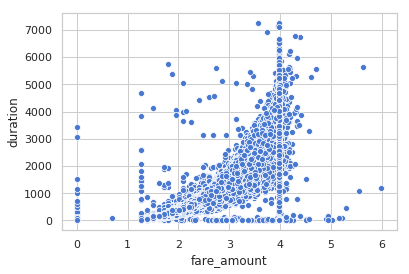

In [30]:
plt7 = sns.scatterplot(x=np.log(np.abs(new_data_df['fare_amount'])+1), y='duration', data=new_data_df);

fig = plt7.get_figure()
fig.savefig('duration vs. log(fare_amount).png');

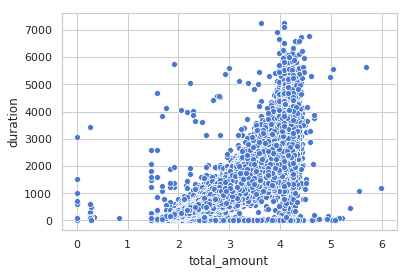

In [31]:
plt8 = sns.scatterplot(x=np.log(np.abs(new_data_df['total_amount'])+1), y='duration', data=new_data_df);

fig = plt8.get_figure()
fig.savefig('duration vs. log(total_amount).png');

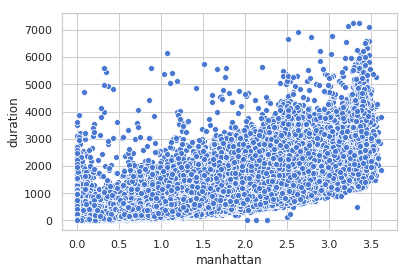

In [32]:
plt9 = sns.scatterplot(x=np.log(new_data_df['manhattan'] + 1), y='duration', data=new_data_df);

fig = plt9.get_figure()
fig.savefig('duration vs. manhattan.png')

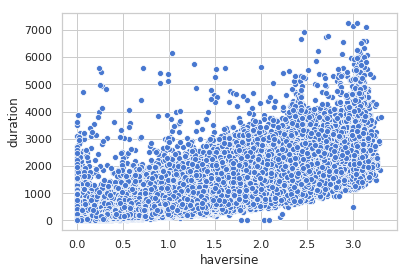

In [33]:
plt10 = sns.scatterplot(x=np.log(new_data_df['haversine'] + 1), y='duration', data=new_data_df);

fig = plt10.get_figure()
fig.savefig('duration vs. haversine.png')

In [34]:
# Add dummies.
featured_df = pd.concat([featured_df, dow, passengers, hour], axis=1)

# Log total_amount, manhattan, and haversine distances
featured_df['log_total_amount'] = np.log(np.abs(featured_df['total_amount']) + 1)
featured_df['log_fare_amount'] = np.log(np.abs(featured_df['fare_amount']) + 1)
featured_df['log_manhattan'] = np.log(featured_df['manhattan'] + 1)
featured_df['log_haversine'] = np.log(featured_df['haversine'] + 1)
featured_df.head()

,record_id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,h_18,h_19,h_20,h_21,h_22,h_23,log_total_amount,log_fare_amount,log_manhattan,log_haversine
0,37300,1,2016-01-01 00:02:20,2016-01-01 00:11:58,2,1.20,-73.990578,40.732883,1,N,...,0,0,0,0,0,0,2.332144,2.197225,1.197455,1.014775
1,37400,1,2016-01-01 00:03:04,2016-01-01 00:28:54,1,5.00,-73.994286,40.749153,1,N,...,0,0,0,0,0,0,3.173460,3.068053,1.473094,1.428693
2,37500,2,2016-01-01 00:03:40,2016-01-01 00:12:47,6,2.54,-73.949821,40.785412,1,N,...,0,0,0,0,0,0,2.636196,2.351375,1.808577,1.540601
3,37900,2,2016-01-01 00:05:38,2016-01-01 00:10:02,3,0.76,-74.002998,40.739220,1,N,...,0,0,0,0,0,0,1.987874,1.791759,0.627740,0.495818
4,38500,1,2016-01-01 00:07:50,2016-01-01 00:23:42,1,2.40,-73.992546,40.766624,1,N,...,0,0,0,0,0,0,2.791165,2.564949,1.423989,1.350991


In [35]:
featured_df = featured_df.drop(['record_id', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'manhattan',
       'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'extra', 'mta_tax', 'tip_amount', 'haversine',
       'tolls_amount', 'improvement_surcharge', 'pickup_date',
       'week_of_year', 'day_of_month', 'week_hour', 'passenger_count',
        'month', 'day_of_week', 'month', 'total_amount', 'hour'], axis=1)

In [36]:
featured_df.shape

(142478, 43)

## Modeling

In [37]:
response = new_data_df['duration']
featured_df = featured_df.drop('duration', axis=1)

In [38]:
# Make test/train split
train_features, val_features, train_response, val_response = train_test_split(featured_df, response, 
                                                                              test_size=0.2, random_state=41)


In [39]:
train_features.head()

,bearing,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,num_pass_1,num_pass_2,...,h_18,h_19,h_20,h_21,h_22,h_23,log_total_amount,log_fare_amount,log_manhattan,log_haversine
130182,-57.470470,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,2.714695,2.397895,0.947625,0.762629
145608,106.650743,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,3.697591,3.417727,2.517170,2.317730
56927,75.307472,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2.230014,1.871802,0.826215,0.718922
28815,28.468668,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,2.791165,2.708050,2.075612,1.814794
24272,-165.317225,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,3.306887,3.157000,1.652814,1.494779


In [40]:
# Grid search to find optimal regularization parameter.
alphas = np.array([10, 1,0.1,0.01,0.001,0.0001,0])
model = lm.Ridge()
scoring = make_scorer(r2_score)

grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas, max_iter=[10, 100, 1000]),
                    scoring=scoring, cv=5, refit=True)
grid.fit(train_features, train_response)
print(grid)

# summarize the results of the grid search
print("Best Parameters: " + str(grid.best_params_))

result = grid.cv_results_
print("R^2 score on training data: %.2f" % grid.score(train_features, train_response))
print("R^2 score on val data: %.2f" 
      % r2_score(val_response, grid.best_estimator_.predict(val_features)))

/srv/conda/envs/data100/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.233357841739868e-21 / 1.1102230246251565e-16
  RuntimeWarning)
/srv/conda/envs/data100/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.233357841739868e-21 / 1.1102230246251565e-16
  RuntimeWarning)
/srv/conda/envs/data100/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.233357841739868e-21 / 1.1102230246251565e-16
  RuntimeWarning)


GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e+01,   1.00000e+00,   1.00000e-01,   1.00000e-02,
         1.00000e-03,   1.00000e-04,   0.00000e+00]), 'max_iter': [10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2_score), verbose=0)
Best Parameters: {'alpha': 1.0, 'max_iter': 10}
R^2 score on training data: 0.80
R^2 score on val data: 0.81


In [41]:
# Since the Best alpha according to the analysis above was 0, we use OLS Regression.
linear_model = lm.LinearRegression()
linear_model.fit(train_features, train_response)

pred_response = linear_model.predict(train_features)

In [42]:
def mae(actual, predicted):
    """
    Calculates MAE from actual and predicted values
    Input:
      actual (1D array-like): vector of actual values
      predicted (1D array-like): vector of predicted/fitted values
    Output:
      a float, the MAE
    """
    
    mae = np.mean(np.abs(actual - predicted))
    return mae

In [43]:
train_error = mae(train_response, linear_model.predict(train_features)) 
test_error = mae(val_response, linear_model.predict(val_features))

print('Training MAE:', train_error)
print('Test MAE:', test_error)

Training MAE: 154.251246516
Test MAE: 153.28402242


## Residual Plots/Assessment

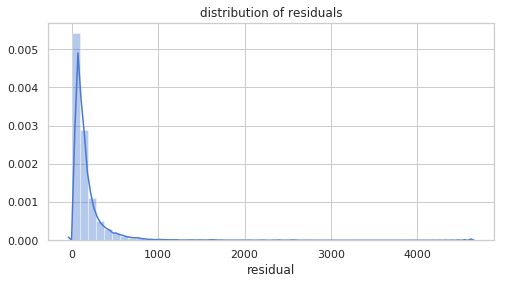

In [44]:
# Distribution of residuals
plt.figure(figsize=(8,4))
plt5 = sns.distplot(np.abs(val_response - linear_model.predict(val_features)))
plt.xlabel('residual')
plt.title('distribution of residuals');

fig = plt5.get_figure()
fig.savefig('residual distribution.png');

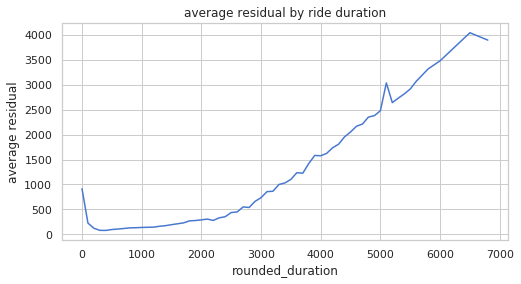

In [45]:
# Average residual grouping by ride duration
val_residual = val_features.copy()
val_residual['duration'] = val_response
val_residual['rounded_duration'] = np.around(val_response, -2)
val_residual['residual'] = np.abs(val_response - linear_model.predict(val_features))
tmp = val_residual.groupby('rounded_duration').mean()
plt.figure(figsize=(8,4))
plt6 = tmp['residual'].plot()
plt.ylabel('average residual')
plt.title('average residual by ride duration');

fig = plt6.get_figure()
fig.savefig('average residual by ride duration.png');

Both plots suggest our model struggles with taxi rides of high duration. However, the right skew in the histogram is minor, and the fact that the residuals are lowest around 500-700 seconds of duration suggests our model handles the average taxi ride well.